In [1]:
# Dependencies
import os
import cv2
import pickle
import shutil
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

# Fix seed to ensure reproducibility
import random
random.seed(42)

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
# RCNN CONFIGURATIONS
CNN_INPUT_SIZE = 224
PADDING = 16

# REGION OF INTEREST CONFIGURATIONS
N_DATASET_PROPOSALS = 2000
N_TRAINING_PROPOSALS = 64
N_INFERENCE_PROPOSALS = 2000
ROI_INPUT_SIZE = 500

# TRAINING CONFIGURATIONS
EPOCHS = 10
BATCH_SIZE = 8
LAMBDA = 10

# OPTIMIZER CONFIGURATIONS
LR = 0.001
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005

# FULL DATA CONFIGURATIONS
IMAGES_PATH = os.path.join("data", "JPEGImages")
ANNOTATIONS_PATH = os.path.join("data", "Annotations")
TRAIN_TEST_RATIO = 0.9
N_CLASSES = 21

# TRAIN DATA PATHS
TRAIN_PATH = os.path.join("data", "train")
TRAIN_IMAGES_PATH = os.path.join(TRAIN_PATH, "images")
TRAIN_ANNOTATIONS_PATH = os.path.join(TRAIN_PATH, "annotations")
DATAPATH = os.path.join(TRAIN_PATH, "data.pkl")
DATAPATH = "./drive/MyDrive/datasets/data.pkl"

# TEST DATA PATHS
TEST_PATH = os.path.join("data", "test")
TEST_IMAGES_PATH = os.path.join(TEST_PATH, "images")
TEST_ANNOTATIONS_PATH = os.path.join(TEST_PATH, "annotations")

# DATASET CONFIGURATIONS
LABEL_NAMES = [
    "background", "aeroplane", "bicycle", "bird",
    "boat", "bottle", "bus", "car", "cat", "chair", "cow",
    "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
    ]

# DEVICE
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# download and extract voc 2008 dataset
# !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2008/VOCtrainval_14-Jul-2008.tar
# !tar -xf VOCtrainval_14-Jul-2008.tar
# shutil.move("./VOCdevkit/VOC2008", "./VOC2008")
# os.rename("./VOC2008/", "./data")

# Dataset

In [4]:
# Create the train and test folders if they don't exist
os.makedirs(TRAIN_IMAGES_PATH, exist_ok=True)
os.makedirs(TRAIN_ANNOTATIONS_PATH, exist_ok=True)
os.makedirs(TEST_IMAGES_PATH, exist_ok=True)
os.makedirs(TEST_ANNOTATIONS_PATH, exist_ok=True)

# Split the images and annotations into train and test sets
IMAGE_NAMES = sorted(os.listdir(IMAGES_PATH))
TRAIN_IMAGE_NAMES = IMAGE_NAMES[:int(len(IMAGE_NAMES)*TRAIN_TEST_RATIO)]
TEST_IMAGE_NAMES = IMAGE_NAMES[int(len(IMAGE_NAMES)*TRAIN_TEST_RATIO):]

# Copy the images to the corresponding train and test folders
for image_name in TRAIN_IMAGE_NAMES:
    image_path = os.path.join(IMAGES_PATH, image_name)
    annot_path = os.path.join(ANNOTATIONS_PATH, image_name.split(".")[0] +".xml")
    shutil.copy(image_path, TRAIN_IMAGES_PATH)
    shutil.copy(annot_path, TRAIN_ANNOTATIONS_PATH)

for image_name in TEST_IMAGE_NAMES:
    image_path = os.path.join(IMAGES_PATH, image_name)
    annot_path = os.path.join(ANNOTATIONS_PATH, image_name.split(".")[0] +".xml")
    shutil.copy(image_path, TEST_IMAGES_PATH)
    shutil.copy(annot_path, TEST_ANNOTATIONS_PATH)

In [5]:
def load_image_annotations(image_name):
    """
    Load annotations for a given image.

    Parameters:
        image_name (str): The name of the image file.

    Returns:
        dict: A dictionary containing image information and annotations.
              The dictionary has the following keys:
              - 'width' (int): The width of the image.
              - 'height' (int): The height of the image.
              - 'area' (int): The area of the image (width * height).
              - 'boxes' (list of tuples): List of bounding boxes in the format (xmin, ymin, xmax, ymax).
              - 'labels' (list of int): List of labels corresponding to each bounding box.

    Raises:
        FileNotFoundError: If the annotations file is not found.

    Example:
        >>> image_info = load_image_annotations('example.jpg')
    """
    # Get annotations file path
    image_name_without_extension = os.path.splitext(image_name)[0]
    annot_file_path = os.path.join(ANNOTATIONS_PATH, image_name_without_extension + '.xml')

    # Parse XML file
    tree = ET.parse(annot_file_path)
    root = tree.getroot()

    # Extract image dimensions
    width = int(root.find(".//size/width").text)
    height = int(root.find(".//size/height").text)

    # Initialize lists to store bounding boxes and labels
    bounding_boxes = []
    labels = []

    for obj in root.findall(".//object"):
        # Extract object name (label)
        label_name = obj.find('name').text

        # Extract bounding box coordinates
        xmin = float(obj.find('.//bndbox/xmin').text)
        ymin = float(obj.find('.//bndbox/ymin').text)
        xmax = float(obj.find('.//bndbox/xmax').text)
        ymax = float(obj.find('.//bndbox/ymax').text)

        bounding_boxes.append((xmin, ymin, xmax, ymax))
        labels.append(LABEL_NAMES.index(label_name))

    return {
        "width": width,
        "height": height,
        "area": width * height,
        "boxes": bounding_boxes,
        "labels": labels,
    }

# Demo : Load image annotations
image_name = random.sample(TRAIN_IMAGE_NAMES, 1)[0]
load_image_annotations(image_name)

{'width': 500,
 'height': 375,
 'area': 187500,
 'boxes': [(73.9796, 45.0073, 331.9971, 375.0)],
 'labels': [15]}

In [6]:
def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters:
        box1 (tuple): Tuple (x1, y1, x2, y2) representing the first bounding box.
        box2 (tuple): Tuple (x1, y1, x2, y2) representing the second bounding box.

    Returns:
        float: Intersection over Union between the two bounding boxes.
    """
    x1_1, y1_1, x2_1, y2_1 = box1
    x1_2, y1_2, x2_2, y2_2 = box2

    # Sanity Check
    assert x1_1 < x2_1 and y1_1 < y2_1, "Box 1 is not valid."
    assert x1_2 < x2_2 and y1_2 < y2_2, "Box 2 is not valid."

    # Calculate the intersection area
    intersection_x1 = max(x1_1, x1_2)
    intersection_y1 = max(y1_1, y1_2)
    intersection_x2 = min(x2_1, x2_2)
    intersection_y2 = min(y2_1, y2_2)

    intersection_area = max(0, intersection_x2 - intersection_x1 + 1) * max(0, intersection_y2 - intersection_y1 + 1)

    # Calculate the area of each bounding box
    area_box1 = (x2_1 - x1_1 + 1) * (y2_1 - y1_1 + 1)
    area_box2 = (x2_2 - x1_2 + 1) * (y2_2 - y1_2 + 1)

    # Calculate the Union area
    union_area = area_box1 + area_box2 - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area

    return iou

# Demo : Calculate IoU
box1 = [10, 10, 50, 50]
box2 = [20, 20, 60, 60]

calculate_iou(box1, box2)

0.40024989587671805

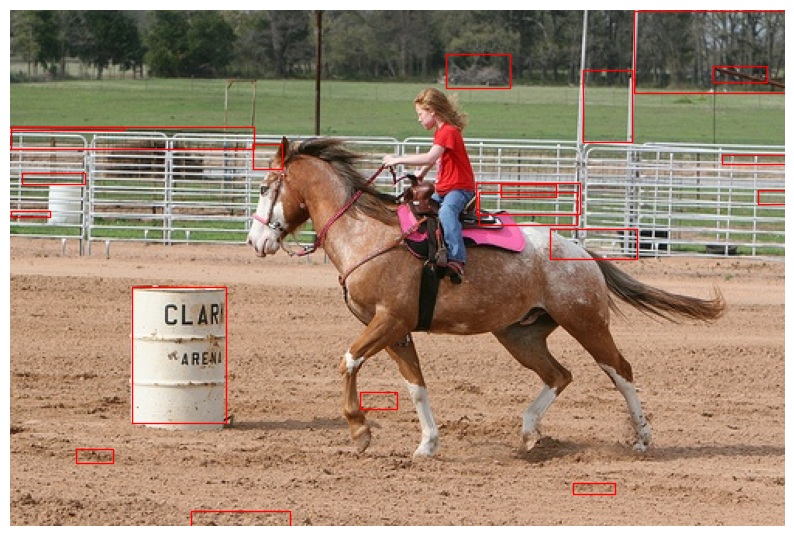

In [7]:
import cv2
import os
import random
import matplotlib.pyplot as plt

def generate_region_proposals(image, num_regions, fast_mode=True):
    """
    Generate region proposals using Selective Search.

    Parameters:
        image (numpy.ndarray): The input image.
        num_regions (int): The number of region proposals to generate.
        fast_mode (bool, optional): Whether to use fast mode for selective search.
                                    Defaults to True.

    Returns:
        list of tuples: A list of region proposals in the format (x1, y1, x2, y2).

    Example:
        >>> image_name = random.sample(TRAIN_IMAGE_NAMES, 1)[0]
        >>> image_path = os.path.join(TRAIN_IMAGES_PATH, image_name)
        >>> image = cv2.imread(image_path)
        >>> image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        >>> regions = generate_region_proposals(image, 20, False)
    """
    # Create a selective search object
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

    # Set the input image for selective search
    ss.setBaseImage(image)

    if fast_mode:
        ss.switchToSelectiveSearchFast()
    else:
        ss.switchToSelectiveSearchQuality()

    # Perform selective search
    regions = ss.process()
    regions = regions[:num_regions]
    regions = [(x, y, x + w, y + h) for x, y, w, h in regions]
    return regions

# Demo : Generate region proposals
image_name = random.sample(TRAIN_IMAGE_NAMES, 1)[0]
image_path = os.path.join(TRAIN_IMAGES_PATH, image_name)
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
regions = generate_region_proposals(image, 20, False)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image)
for xmin, ymin, xmax, ymax in regions:
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='red', linewidth=1)
    ax.add_patch(rect)
plt.axis('off')
plt.show()


In [8]:
def generate_rcnn_dataset(data_path, iou_threshold=0.5, sample_ratio=1/3):
    """
    Generate a dataset for RCNN training.

    Args:
        data_path (str): Path to the dataset.
        iou_threshold (float): IoU threshold for object proposals.
        sample_ratio (float): Ratio of background samples to object samples.

    Returns:
        dict: Dictionary containing image names, region of interest (ROI) boxes,
              annotation boxes, and labels.
    """
    # Get image names
    images_path = os.path.join(data_path, "images")
    image_names = sorted(os.listdir(images_path))

    nb_objects = 0
    nb_background = 0

    # Intiliaze lists to store images, bounding boxes and labels
    data = {
        "image_names": [],
        "roi_boxes": [],
        "annot_boxes": [],
        "labels": []
    }

    for i, image_name in enumerate(image_names):
        if i % 100 == 99:
            print(f"Processing image {i+1}/{len(image_names)}")

        # Load image
        image = cv2.imread(os.path.join(images_path, image_name))
        h, w, _ = image.shape
        image = cv2.resize(image, (ROI_INPUT_SIZE, ROI_INPUT_SIZE))

        # Load ground truth annotations
        gt_annots = load_image_annotations(image_name)
        gt_bboxes = gt_annots["boxes"]
        gt_labels = gt_annots["labels"]

        # Generate region proposals
        roi_bboxes = generate_region_proposals(image, N_DATASET_PROPOSALS, fast_mode=False)

        for bbox in roi_bboxes:
            # Adapt the bbox to the original image size
            bbox = (
                int(bbox[0] * w / ROI_INPUT_SIZE),
                int(bbox[1] * h / ROI_INPUT_SIZE),
                int(bbox[2] * w / ROI_INPUT_SIZE),
                int(bbox[3] * h / ROI_INPUT_SIZE)
            )
            # Compute IoU between the region proposal
            # and all ground truth bounding boxes
            iou_max = 0
            for gt_label, gt_bbox in zip(gt_labels, gt_bboxes):
                iou = calculate_iou(bbox, gt_bbox)
                iou_max = max(iou_max, iou)

                # Fine-Tuning (CNN) : Proposals with IoU > iou_threshold are objects
                if iou >= iou_threshold:
                    data["image_names"].append(image_name)
                    data["roi_boxes"].append(bbox)
                    data["annot_boxes"].append(gt_bbox)
                    data["labels"].append(gt_label)
                    nb_objects += 1

            # Fine-Tuning (CNN) : Proposals with IoU < iou_threshold are background
            ratio_is_respected = (nb_background * sample_ratio <= nb_objects)
            if (iou_max < iou_threshold) and ratio_is_respected:
                data["image_names"].append(image_name)
                data["roi_boxes"].append(bbox)
                data["annot_boxes"].append(bbox)
                data["labels"].append(0)
                nb_background += 1

    return data

In [9]:
# If the dataset has already been generated, load it
if os.path.exists(DATAPATH):
    data = pickle.load(open(DATAPATH, "rb"))

# If not, generate and save it to disk
else:
    data = generate_rcnn_dataset(TRAIN_PATH)
    with open(DATAPATH, "wb") as f:
        pickle.dump(data, f)

In [10]:
from torch.utils.data import Dataset

class FastRCNNDataset(Dataset):
    def __init__(self, root, data, batch_size, transform=None):
        """
        Args:
            root (str): Root directory of the dataset.
            data (dict): Dictionary containing image names, region of interest (ROI) boxes,
                         annotation boxes, and labels.
            batch_size (int): Batch size for training.
            transform (callable, optional): Optional transform to be applied on an image sample.
        """
        self.root = root
        self.transform = transform
        self.image_names = np.array(data["image_names"])
        self.annot_boxes = np.array(data["annot_boxes"])
        self.roi_boxes = np.array(data["roi_boxes"])
        self.labels = np.array(data["labels"])
        self.batch_size = batch_size

        # Get the foreground and background masks
        self.background_mask = (self.labels == 0)
        self.foreground_mask = ~ self.background_mask
        n_foreground = np.sum(self.foreground_mask)
        n_background = np.sum(self.background_mask)
        print(f"N# Foreground : {n_foreground}, N# Background : {n_background}")

        # Compute the targets
        Gx = (self.annot_boxes[:, 2] + self.annot_boxes[:, 0]) / 2
        Gy = (self.annot_boxes[:, 3] + self.annot_boxes[:, 1]) / 2
        Gw = (self.annot_boxes[:, 2] - self.annot_boxes[:, 0])
        Gh = (self.annot_boxes[:, 3] - self.annot_boxes[:, 1])

        Px = (self.roi_boxes[:, 2] + self.roi_boxes[:, 0]) / 2
        Py = (self.roi_boxes[:, 3] + self.roi_boxes[:, 1]) / 2
        Pw = (self.roi_boxes[:, 2] - self.roi_boxes[:, 0])
        Ph = (self.roi_boxes[:, 3] - self.roi_boxes[:, 1])

        eps = 1e-6
        dx = (Gx - Px) / (Pw + eps)
        dy = (Gy - Py) / (Ph + eps)
        dw = np.log((Gw + eps) / (Pw + eps))
        dh = np.log((Gh + eps) / (Ph + eps))

        self.targets = np.vstack((dx, dy, dw, dh)).T

        # Get list of unique image names
        self.unique_image_names = np.unique(self.image_names)

    def __len__(self):
        return len(self.unique_image_names)

    def __getitem__(self, index):
        """
        Args:
            index (int): Index of the unique image name.

        Returns:
            dict: Dictionary containing image, annotation boxes, targets, ROI boxes, and labels.
        """
        image_name = self.unique_image_names[index]

        # Load image
        image_path = os.path.join(self.root, "images", image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w, _ = image.shape

        if self.transform:
            image = self.transform(image)

        # Get image mask
        image_mask = (self.image_names == image_name)

        # Get foreground and background masks
        background_mask = self.background_mask & image_mask
        foreground_mask = self.foreground_mask & image_mask

        # Select random 16 foregound proposals
        # If there are less than 16 proposals, select all of them
        foreground_indices = np.where(foreground_mask)[0]
        np.random.shuffle(foreground_indices)
        foreground_indices = foreground_indices[:16]
        annot_boxes = self.annot_boxes[foreground_indices]
        roi_boxes = self.roi_boxes[foreground_indices]
        labels = self.labels[foreground_indices]
        targets = self.targets[foreground_indices]

        # Select random 48 background proposals
        # If there are less than 48 foreground proposals, select all of them
        background_indices = np.where(background_mask)[0]
        np.random.shuffle(background_indices)
        background_indices = background_indices[:48]
        annot_boxes = np.concatenate((annot_boxes, self.annot_boxes[background_indices]), axis=0)
        roi_boxes = np.concatenate((roi_boxes, self.roi_boxes[background_indices]), axis=0)
        labels = np.concatenate((labels, self.labels[background_indices]), axis=0)
        targets = np.concatenate((targets, self.targets[background_indices]), axis=0)

        # Adapt boxes to the image size (h, w) and the CNN input size
        annot_boxes = np.array([
            (
                int(bbox[0] * CNN_INPUT_SIZE/ w),
                int(bbox[1] * CNN_INPUT_SIZE/ h),
                int(bbox[2] * CNN_INPUT_SIZE/ w),
                int(bbox[3] * CNN_INPUT_SIZE/ h)
            )
            for bbox in annot_boxes
        ])
        roi_boxes = np.array([
            (
                int(bbox[0] * CNN_INPUT_SIZE/ w),
                int(bbox[1] * CNN_INPUT_SIZE/ h),
                int(bbox[2] * CNN_INPUT_SIZE/ w),
                int(bbox[3] * CNN_INPUT_SIZE/ h)
            )
            for bbox in roi_boxes
        ])

        # Permute annot boxes, roi boxes and the labels
        perm = np.random.permutation(len(labels))
        annot_boxes = torch.Tensor(annot_boxes[perm])
        roi_boxes = torch.Tensor(roi_boxes[perm])
        labels = torch.Tensor(labels[perm])

        return {
            "images": image,
            "annot_boxes": torch.Tensor(annot_boxes),
            "targets": torch.Tensor(targets),
            "roi_boxes": torch.Tensor(roi_boxes),
            "labels": torch.Tensor(labels)
        }


N# Foreground : 172473, N# Background : 517417
torch.Size([8, 64, 4])


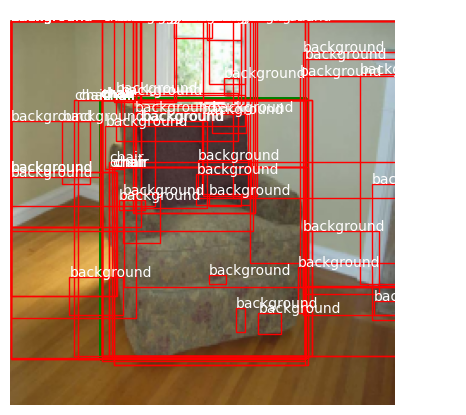

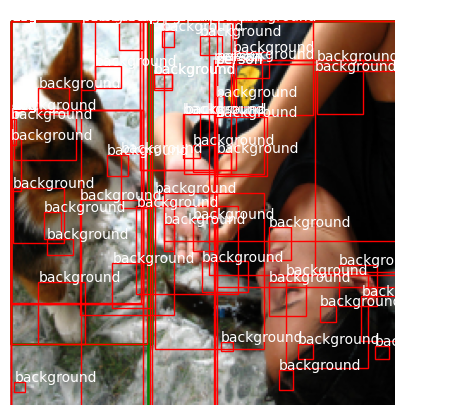

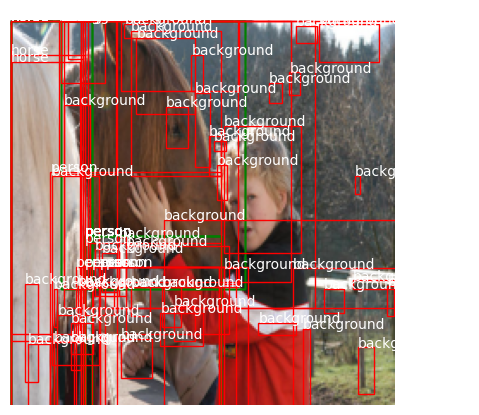

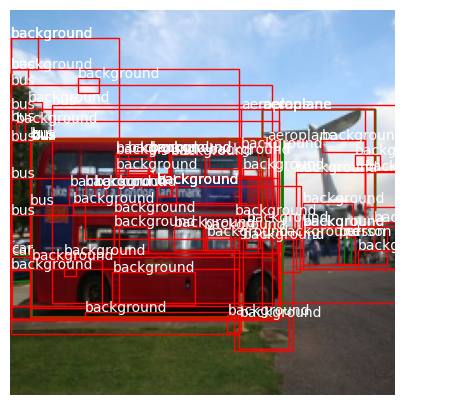

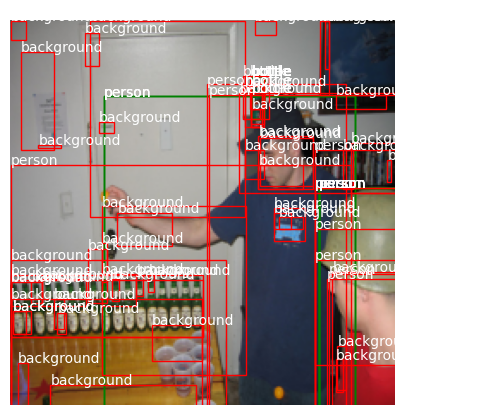

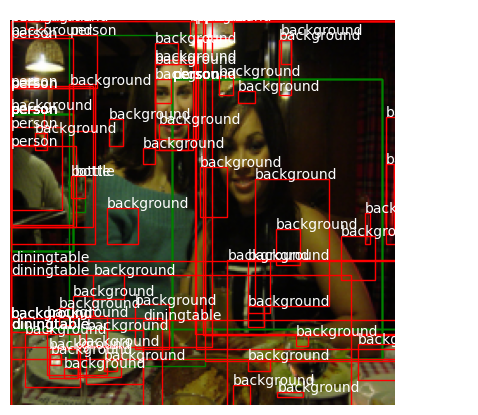

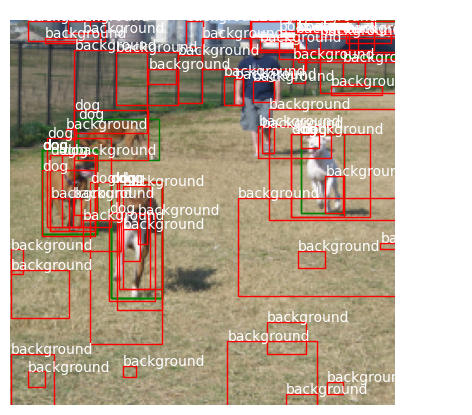

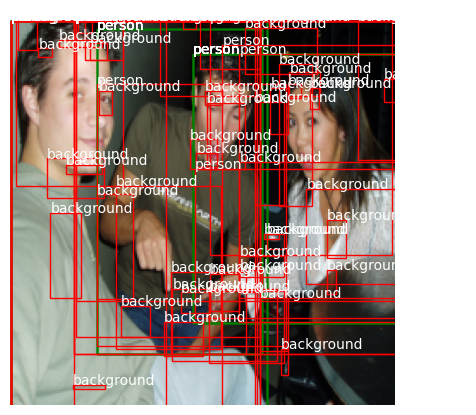

In [11]:
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((CNN_INPUT_SIZE, CNN_INPUT_SIZE)),
    transforms.ToTensor(),
])

def custom_collate_fn(batch):
    """
    Custom collate function to handle padding and stacking for variable-sized inputs.

    Args:
        batch (list): List of samples, where each sample is a dictionary containing
                      images, annotation boxes, ROI boxes, labels, and targets.

    Returns:
        dict: Dictionary containing stacked tensors for images, annotation boxes, ROI boxes, labels, and targets.
    """
    # Calculate the maximum number of samples in the batch
    max_samples = max(len(sample["labels"]) for sample in batch)

    # Pad each sample to have the same number of samples
    for sample in batch:
        padding = max_samples - len(sample["labels"])
        sample["annot_boxes"] = torch.nn.functional.pad(sample["annot_boxes"], (0, 0, 0, padding))
        sample["roi_boxes"] = torch.nn.functional.pad(sample["roi_boxes"], (0, 0, 0, padding))
        sample["labels"] = torch.nn.functional.pad(sample["labels"], (0, padding), value=-1)
        sample["targets"] = torch.nn.functional.pad(sample["targets"], (0, 0, 0, padding))

    # Stack the tensors to create the batch
    batch = {
        "images": torch.stack([sample["images"] for sample in batch]),
        "annot_boxes": torch.stack([sample["annot_boxes"] for sample in batch]),
        "roi_boxes": torch.stack([sample["roi_boxes"] for sample in batch]),
        "labels": torch.stack([sample["labels"] for sample in batch]),
        "targets": torch.stack([sample["targets"] for sample in batch])
    }

    return batch


# Generate the datasets and dataloaders
dataset = FastRCNNDataset(TRAIN_PATH, data, BATCH_SIZE, transform=transform)
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle=True, collate_fn=custom_collate_fn)

# Demo : Display a batch of images
batch = next(iter(dataloader))
images = batch["images"]
annot_boxes = batch["annot_boxes"]
roi_boxes = batch["roi_boxes"]
labels = batch["labels"]

print(annot_boxes.shape)

for i in range(BATCH_SIZE):
    _image = images[i]
    _annot_boxes = annot_boxes[i]
    _roi_boxes = roi_boxes[i]
    _labels = labels[i]

    padding_mask = (_labels == -1)
    _annot_boxes = _annot_boxes[~padding_mask]
    _roi_boxes = _roi_boxes[~padding_mask]
    _labels = _labels[~padding_mask]

    # Convert PyTorch tensor to numpy array
    _image = _image.permute(1, 2, 0).numpy()

    # Visualize
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(_image)
    for label, annot_box in zip(_labels, _annot_boxes):
        if label != 0:
            xmin, ymin, xmax, ymax = annot_box
            rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='green', linewidth=1)
            ax.add_patch(rect)
            ax.text(xmin, ymin, LABEL_NAMES[int(label)], fontsize=10, color='white')

    for label, roi_box in zip(_labels, _roi_boxes):
        xmin, ymin, xmax, ymax = roi_box
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)
        ax.text(xmin, ymin, LABEL_NAMES[int(label)], fontsize=10, color='white')
    plt.axis('off')
    plt.show()

## Model

In [15]:
from torchvision.models import vgg16, VGG16_Weights
from torchvision.ops import roi_pool

# Feature Extractor
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.feature_extractor = vgg16(weights=VGG16_Weights.DEFAULT)
        self.feature_extractor = nn.Sequential(*list(self.feature_extractor.features.children())[:-1])

    def forward(self, x):
        return self.feature_extractor(x)

# Classification Head
class ClassHead(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.classifier = nn.Linear(4096, num_classes)

    def forward(self, x):
        return self.classifier(x)

# Bounding Box Regression Head
class BoxHead(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.bbox_regressor = nn.Linear(4096, num_classes * 4)

    def forward(self, x):
        return self.bbox_regressor(x)

# Fast RCNN Model
class FastRCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.feature_extractor = FeatureExtractor()
        self.class_scores = ClassHead(num_classes)
        self.bbox_pred = BoxHead(num_classes)
        self.fc1 = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25)
        )

    def forward(self, x, rois):
        # Extract features
        features = self.feature_extractor(x)

        # Apply ROI pooling
        pooled_features = roi_pool(features, rois, output_size=(7, 7), spatial_scale=1/16)

        # Flatten pooled features
        pooled_features = pooled_features.view(pooled_features.size(0), -1)

        # Fully connected layers
        x = self.fc1(pooled_features)

        x = self.fc2(x)

        # Classification scores
        class_scores = self.class_scores(x)

        # Bounding box regression
        bbox_deltas = self.bbox_pred(x)

        return class_scores, bbox_deltas

## Training Loop

In [13]:
from torch.optim.lr_scheduler import StepLR

def train(model, data_loader, num_epochs, lr, momentum, weight_decay, device):
    """
    Train the RCNN model.

    Args:
        model (nn.Module): RCNN model.
        data_loader (DataLoader): DataLoader for the training data.
        num_epochs (int): Number of epochs.
        lr (float): Learning rate.
        momentum (float): SGD momentum.
        weight_decay (float): L2 regularization weight.
        device (torch.device): Device for computation (cpu or cuda).

    Returns:
        nn.Module: Trained RCNN model.
    """
    # Loss functions
    cls_criterion = nn.CrossEntropyLoss()
    reg_criterion = nn.SmoothL1Loss()

    # Optimizer and scheduler
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.5, verbose=True)

    # Training
    model.train()
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        running_cls_loss = 0.0
        running_reg_loss = 0.0

        # To compute general accuracy (including background)
        correct_predictions = 0
        total_samples = 0

        # To compute objects accuracy (excluding background)
        correct_non_background_predictions = 0
        non_background_total_samples = 0

        for step, data in enumerate(data_loader):
            # Get data
            images = data['images'].to(device)
            roi_boxes = data['roi_boxes'].to(device)
            targets = data['targets'].to(device)
            labels = data['labels'].to(device)

            # Format to match the expected format
            batch_size, num_boxes, _ = roi_boxes.shape
            batch_indices = torch.arange(batch_size).view(-1, 1, 1).expand(-1, num_boxes, 1).to(device)
            roi_boxes = torch.cat((batch_indices, roi_boxes), dim=2)
            roi_boxes = roi_boxes.view(-1, 5)
            targets = targets.view(-1, 4)
            labels = labels.view(-1)

            # Mask padded samples
            padding_mask = (labels != -1)
            roi_boxes = roi_boxes[padding_mask]
            labels = labels[padding_mask].long()
            targets = targets[padding_mask]

            # Forward pass
            optimizer.zero_grad()
            cls_pred, bbox_deltas = model(images, roi_boxes)

            # Compute classification loss
            cls_loss = cls_criterion(cls_pred, labels)

            # compute accuracy
            _, predicted = torch.max(cls_pred.data, 1)
            total_samples += labels.size(0)
            non_background_total_samples += (labels != 0).sum().item()
            correct_predictions += (predicted == labels).sum().item()
            correct_non_background_predictions += ((predicted == labels) & (labels != 0)).sum().item()

            # Compute bounding box regression loss
            # Mask background
            background_mask = (labels > 0)
            targets = targets[background_mask, :]
            bbox_deltas = bbox_deltas[background_mask, :]
            roi_boxes = roi_boxes[background_mask, :]
            labels = labels[background_mask]

            class_specific_bbox_deltas = torch.zeros_like(targets)
            for i in range(len(labels)):
                label = labels[i]
                class_specific_bbox_deltas[i] = bbox_deltas[i, 4*label:4*label+4]

            reg_loss = reg_criterion(class_specific_bbox_deltas, targets)

            # Compute total loss
            loss = cls_loss + LAMBDA * reg_loss
            loss.backward()
            optimizer.step()

            # Update running loss and accuracy
            running_cls_loss += loss.item()
            running_reg_loss += loss.item()

            # Check for NaN values
            if torch.isnan(loss):
                print("NaN loss detected.")
                break

            if step % 30 == 29:
                print(f"Step {step+1}/{len(data_loader)} completed"
                      f" - loss {loss:.2f}"
                      f" - cls loss {cls_loss:.2f}"
                      f" - reg loss {reg_loss:.5f}"
                      f" - accuracy {100 * correct_predictions / total_samples:.2f}%"
                      f" - accuracy excluding background {100 * correct_non_background_predictions / non_background_total_samples:.2f}%")

        # Update learning rate (/2)
        scheduler.step()

        # Calculate and print epoch statistics
        epoch_cls_loss = running_cls_loss / total_samples
        epoch_accuracy = correct_predictions / total_samples

        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Classification Loss: {epoch_cls_loss:.4f}, "
              f"Accuracy: {100 * epoch_accuracy:.2f}%")


    return model

In [17]:
# Fine tuning the feature extractor and the classifier
model = FastRCNN(N_CLASSES)
model = model.to(DEVICE)

model = train(model, dataloader, 5, LR, MOMENTUM, WEIGHT_DECAY, DEVICE)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 1/5
Step 30/569 completed - loss 1.63 - cls loss 1.53 - reg loss 0.00934 - accuracy 66.47% - accuracy excluding background 0.82%
Step 60/569 completed - loss 1.30 - cls loss 1.21 - reg loss 0.00901 - accuracy 70.80% - accuracy excluding background 0.40%
Step 90/569 completed - loss 1.24 - cls loss 1.14 - reg loss 0.00934 - accuracy 72.33% - accuracy excluding background 0.76%
Step 120/569 completed - loss 1.13 - cls loss 1.02 - reg loss 0.01026 - accuracy 73.57% - accuracy excluding background 3.27%
Step 150/569 completed - loss 1.02 - cls loss 0.94 - reg loss 0.00777 - accuracy 74.76% - accuracy excluding background 6.78%
Step 180/569 completed - loss 1.02 - cls loss 0.94 - reg loss 0.00777 - accuracy 75.55% - accuracy excluding background 9.40%
Step 210/569 completed - loss 0.90 - cls loss 0.82 - reg loss 0.00824 - accuracy 76.08% - accuracy excluding background 11.24%
Step 240/569 completed - loss 0.96 - cls loss 0.87 - reg los

In [18]:
path = "./drive/MyDrive/models/fast_rcnn_model.pkl"
torch.save(model.state_dict(), path)

# model.load_state_dict(torch.load(path))
# model = model.to(DEVICE)

In [19]:
from torchvision.ops import nms
import math

def inference(model, image, apply_nms=False, box_reg=False, transform=None, iou_threshold=0.5, bbox_xform_clip=math.log(1000.0 / (16*2))):
    """
    Perform inference using the RCNN model.

    Args:
        model (nn.Module): RCNN model.
        image (numpy.ndarray): Input image.
        apply_nms (bool): Whether to apply non-maximum suppression.
        box_reg (bool): Whether to apply bounding box regression.
        transform (callable, optional): Image transformation function.
        iou_threshold (float, optional): IoU threshold for NMS.
        bbox_xform_clip (float, optional): Bounding box transformation clipping value.

    Returns:
        dict: Dictionary containing labels, scores, and bounding boxes.
    """
    # Generate RoI proposals
    roi_proposals = generate_region_proposals(image, N_INFERENCE_PROPOSALS, fast_mode=False)
    h, w, _ = image.shape
    roi_proposals = np.array([
        (
            int(bbox[0] * CNN_INPUT_SIZE/ w),
            int(bbox[1] * CNN_INPUT_SIZE/ h),
            int(bbox[2] * CNN_INPUT_SIZE/ w),
            int(bbox[3] * CNN_INPUT_SIZE/ h)
        )
        for bbox in roi_proposals
    ])
    roi_proposals = torch.Tensor(roi_proposals)
    roi_proposals = torch.unsqueeze(roi_proposals, dim=0)

    # Transform the image
    if transform:
        image = transform(image)
        image = torch.unsqueeze(image, 0)
        image = image.to(DEVICE)

    # Stack the RoIs into a single tensor
    # and add a batch dimension
    batch_size, num_boxes, _ = roi_proposals.shape
    batch_indices = torch.arange(batch_size).view(-1, 1, 1).expand(-1, num_boxes, 1)
    roi_proposals = torch.cat((batch_indices, roi_proposals), dim=2)
    roi_proposals = roi_proposals.view(-1, 5)
    roi_proposals = roi_proposals.to(DEVICE)

    model.eval()
    with torch.no_grad():
        cls_pred, boxes_deltas = model(image, roi_proposals)

    # get labels and scores from cls_pred
    scores, labels = torch.max(cls_pred, dim=1)

    # Background mask
    background_mask = (labels != 0)
    labels = labels[background_mask]
    scores = scores[background_mask]
    roi_proposals = roi_proposals[background_mask, 1:]

    # Transform bounding boxes
    boxes = []
    if box_reg:
        for i in range(len(roi_proposals)):
            # Proposal
            P = roi_proposals[i]
            Px = (P[0] + P[2]) / 2
            Py = (P[1] + P[3]) / 2
            Pw = (P[2] - P[0])
            Ph = (P[3] - P[1])

            # Transformation
            label = int(labels[i])
            d = boxes_deltas[i, 4*label:4*label+4]
            dx, dy, dw, dh = d

            # Prevent sending too large values into torch.exp()
            dw = torch.clamp(dw, max=bbox_xform_clip)
            dh = torch.clamp(dh, max=bbox_xform_clip)

            # Transform box
            Gx = int(Px + Pw * dx)
            Gy = int(Py + Ph * dy)
            Gw = int(Pw * torch.exp(dw))
            Gh = int(Ph * torch.exp(dh))

            # Append box
            boxes.append((Gx - Gw/2, Gy - Gh/2, Gx + Gw/2, Gy + Gh/2))

        # To tensor
        boxes = torch.Tensor(boxes).to(DEVICE)
    else:
        boxes = roi_proposals

    # Apply non-maximum suppression
    if apply_nms:
        keep = nms(boxes, scores, iou_threshold)
        labels = labels[keep]
        scores = scores[keep]
        boxes = boxes[keep]

    # Transform boxes to original size
    boxes = np.array([
        (
            int(bbox[0] * w / CNN_INPUT_SIZE),
            int(bbox[1] * h / CNN_INPUT_SIZE),
            int(bbox[2] * w / CNN_INPUT_SIZE),
            int(bbox[3] * h / CNN_INPUT_SIZE)
        )
        for bbox in boxes
    ])

    # Transform to lists
    labels = labels.cpu().tolist()
    scores = scores.cpu().tolist()
    boxes = boxes.tolist()

    return {"labels": labels, "scores": scores, "boxes": boxes}


In [ ]:
import random

# Shuffle the list of image names
random.shuffle(TEST_IMAGE_NAMES)

# Select a subset (e.g., first 100)
selected_image_names = TEST_IMAGE_NAMES[:100]

for image_name in selected_image_names:
    image_path = os.path.join(TEST_IMAGES_PATH, image_name)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    detection = inference(model, image, transform=transform, apply_nms = True, box_reg = False, iou_threshold=0.15)

    # visualize the image and the detections on it
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)
    h, w, _ = image.shape
    for label, score, box in zip(detection["labels"], detection["scores"], detection["boxes"]):
        if score > 5:
            x1, y1, x2, y2 = box
            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(x2, w)
            y2 = min(y2, h)
            width = x2 - x1
            height = y2 - y1
            rect = plt.Rectangle((x1, y1), width, height, fill=False, color="red")
            ax.add_patch(rect)
            ax.text(x1, y1, f"{LABEL_NAMES[label]} - {score:.2f}%", color="white", fontsize=15)
    plt.show()

In [ ]:
import random

# Shuffle the list of image names
random.shuffle(TEST_IMAGE_NAMES)

# Select a subset (e.g., first 20)
selected_image_names = TEST_IMAGE_NAMES[:20]

for image_name in selected_image_names:
    image_path = os.path.join(TEST_IMAGES_PATH, image_name)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    detection = inference(model, image, transform=transform, apply_nms = True, box_reg = True, iou_threshold=0.15)

    # visualize the image and the detections on it
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)
    h, w, _ = image.shape
    for label, score, box in zip(detection["labels"], detection["scores"], detection["boxes"]):
        if score > 5:
            x1, y1, x2, y2 = box
            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(x2, w)
            y2 = min(y2, h)
            width = x2 - x1
            height = y2 - y1
            rect = plt.Rectangle((x1, y1), width, height, fill=False, color="red")
            ax.add_patch(rect)
            ax.text(x1, y1, f"{LABEL_NAMES[label]} - {score:.2f}%", color="white", fontsize=15)
    plt.show()